In [35]:

import pandas as pd 
import os 
from datetime import datetime 
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import mannwhitneyu, normaltest
import statsmodels.stats.multitest as sm
from scipy import stats
from lifelines import KaplanMeierFitter

# from utils import *


In [223]:
current_directory = os.getcwd()
print(current_directory)
# date = datetime.now().strftime("%Y%m%d")
pi = pd.read_excel('Data/raw/LUAD Clinical Data.xlsx')

# Get current directory
current_directory = os.getcwd()
data_path = current_directory + '/Data/'

# Set path 
df = pd.read_csv(f"{data_path}/clustered/full_cd_clus_20_40_49.csv").rename(columns={'cluster': 'agglomerateto_275'})
df_loc = pd.read_csv(f"{data_path}/celldata/celldata_20240313.csv")[['cellID', 'Location_Center_X', 'Location_Center_Y']].rename(columns={'cellID': 'source_ID', 'cluster': 'agglomerateto_275'})

# Merge location data 
df_full= pd.merge(df, df_loc, on='source_ID', how='inner')


c:\Users\jhroe\Desktop\Thesis\Clean\CellularCommunityAnalysisNSCLC\Sorin


In [227]:
df_full

,Patient_ID,source_ID,source_cluster,Alt.MAC,B.cell,Cancer,Cl.MAC,Cl.Mo,DCs.cell,Endothelial.cell,...,Th,Treg,Unknown,agglomerateto_275,agglomerateto_20,agglomerateto_40,agglomerateto_49,surv_5y,Location_Center_X,Location_Center_Y
0,LUAD_D001,D001_0,Cancer,0.166667,0.000000,0.166667,0.166667,0.000000,0.0,0.000000,...,0.333333,0.0,0.000000,1,7,27,27,1,93,159
1,LUAD_D001,D001_1000,Treg,0.000000,0.000000,0.000000,0.083333,0.000000,0.0,0.083333,...,0.250000,0.0,0.333333,1,7,27,27,1,782,270
2,LUAD_D001,D001_1010,Unknown,0.000000,0.000000,0.000000,0.000000,0.333333,0.0,0.000000,...,0.000000,0.0,0.166667,1,7,27,27,1,733,371
3,LUAD_D001,D001_1011,Unknown,0.000000,0.000000,0.000000,0.181818,0.090909,0.0,0.000000,...,0.181818,0.0,0.181818,1,7,27,27,1,757,278
4,LUAD_D001,D001_1013,Unknown,0.142857,0.000000,0.000000,0.000000,0.142857,0.0,0.071429,...,0.214286,0.0,0.285714,1,7,27,27,1,772,218
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1637717,LUAD_D213,D213_1771,Cancer,0.000000,0.076923,0.923077,0.000000,0.000000,0.0,0.000000,...,0.000000,0.0,0.000000,274,9,19,19,1,174,668
1637718,LUAD_D213,D213_2703,Cancer,0.000000,0.090909,0.909091,0.000000,0.000000,0.0,0.000000,...,0.000000,0.0,0.000000,274,9,19,19,1,190,710
1637719,LUAD_D213,D213_4040,Cancer,0.000000,0.100000,0.900000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.0,0.000000,274,9,19,19,1,165,687
1637720,LUAD_D213,D213_4896,Cancer,0.000000,0.066667,0.933333,0.000000,0.000000,0.0,0.000000,...,0.000000,0.0,0.000000,274,9,19,19,1,219,695


In [230]:
df_pi = pi[['Survival or loss to follow-up (years)', 'Key', 'Death (No: 0, Yes: 1)']].rename(columns={'Key':'Patient_ID', 'Survival or loss to follow-up (years)':'survival', 'Death (No: 0, Yes: 1)':'death'}, inplace=False)

df_pi

,survival,Patient_ID,death
0,8.386,LUAD_D001,1
1,10.111,LUAD_D002,0
2,2.094,LUAD_D003,1
3,1.755,LUAD_D004,1
4,7.598,LUAD_D005,1
...,...,...,...
411,9.944,LUAD_D412,0
412,8.132,LUAD_D413,0
413,8.550,LUAD_D414,0
414,1.862,LUAD_D415,1


In [231]:
df_pi

,survival,Patient_ID,death
0,8.386,LUAD_D001,1
1,10.111,LUAD_D002,0
2,2.094,LUAD_D003,1
3,1.755,LUAD_D004,1
4,7.598,LUAD_D005,1
...,...,...,...
411,9.944,LUAD_D412,0
412,8.132,LUAD_D413,0
413,8.550,LUAD_D414,0
414,1.862,LUAD_D415,1


In [240]:
treg_clusters_40 = [28, 26, 27, 37, 5, 24, 34, 22, 39, 12]
data = df_full[['Patient_ID', 'agglomerateto_40', 'surv_5y']]
data

,Patient_ID,agglomerateto_40,surv_5y
0,LUAD_D001,27,1
1,LUAD_D001,27,1
2,LUAD_D001,27,1
3,LUAD_D001,27,1
4,LUAD_D001,27,1
...,...,...,...
1637717,LUAD_D213,19,1
1637718,LUAD_D213,19,1
1637719,LUAD_D213,19,1
1637720,LUAD_D213,19,1


In [243]:
count_data = data.groupby(['Patient_ID', 'agglomerateto_40', 'surv_5y']).size().reset_index(name='count')
total_clus = count_data.groupby(['Patient_ID', 'surv_5y'])['count'].sum().reset_index(name='total_clus')

count_data

,Patient_ID,agglomerateto_40,surv_5y,count
0,LUAD_D001,1,1,12
1,LUAD_D001,2,1,3
2,LUAD_D001,3,1,81
3,LUAD_D001,4,1,198
4,LUAD_D001,5,1,1378
...,...,...,...,...
13251,LUAD_D416,36,1,7
13252,LUAD_D416,37,1,13
13253,LUAD_D416,38,1,10
13254,LUAD_D416,39,1,177


In [244]:
count_df = pd.merge(count_data, total_clus, on=['Patient_ID','surv_5y'])
# totalscid = count_df['total_scid']
# print(count_df.head())
count_df['relative_frequency'] = (count_df['count'] / count_df['total_clus'])
count_df = pd.merge(count_df, df_pi, on=['Patient_ID'])

count_df

,Patient_ID,agglomerateto_40,surv_5y,count,total_clus,relative_frequency,survival,death
0,LUAD_D001,1,1,12,4517,0.002657,8.386,1
1,LUAD_D001,2,1,3,4517,0.000664,8.386,1
2,LUAD_D001,3,1,81,4517,0.017932,8.386,1
3,LUAD_D001,4,1,198,4517,0.043834,8.386,1
4,LUAD_D001,5,1,1378,4517,0.305070,8.386,1
...,...,...,...,...,...,...,...,...
13251,LUAD_D416,36,1,7,2879,0.002431,9.386,0
13252,LUAD_D416,37,1,13,2879,0.004515,9.386,0
13253,LUAD_D416,38,1,10,2879,0.003473,9.386,0
13254,LUAD_D416,39,1,177,2879,0.061480,9.386,0


In [245]:
count_df['agglomerateto_40'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 11, 12, 13, 14, 15, 16, 17, 19,
       20, 21, 22, 23, 24, 25, 26, 27, 30, 31, 33, 34, 35, 36, 37, 38, 39,
       40, 18, 28, 10, 29, 32], dtype=int64)

In [262]:
# select the clusters with highest t reg prevalence

boxplot_df_toptreg = count_df.loc[count_df['agglomerateto_40'].isin(treg_clusters_40)][['Patient_ID', 'agglomerateto_40', 'surv_5y', 'death', 'relative_frequency']]

# Drop patients that got lost before 5 years
boxplot_df_toptreg = boxplot_df_toptreg[~((boxplot_df_toptreg['surv_5y'] == 0) & (boxplot_df_toptreg['death'] == 0))]

boxplot_df_toptreg

,Patient_ID,agglomerateto_40,surv_5y,death,relative_frequency
4,LUAD_D001,5,1,1,0.305070
10,LUAD_D001,12,1,1,0.001328
19,LUAD_D001,22,1,1,0.001328
21,LUAD_D001,24,1,1,0.000221
23,LUAD_D001,26,1,1,0.043392
...,...,...,...,...,...
13243,LUAD_D416,27,1,0,0.151094
13244,LUAD_D416,28,1,0,0.000695
13249,LUAD_D416,34,1,0,0.006252
13252,LUAD_D416,37,1,0,0.004515


In [261]:
# Select all clusters
boxplot_df_all = count_df[['Patient_ID', 'agglomerateto_40', 'surv_5y', 'death', 'relative_frequency']]

# Drop patients that got lost before 5 years
boxplot_df_all = boxplot_df_all[~((boxplot_df_all['surv_5y'] == 0) & (boxplot_df_all['death'] == 0))]

boxplot_df_all


,Patient_ID,agglomerateto_40,surv_5y,death,relative_frequency
0,LUAD_D001,1,1,1,0.002657
1,LUAD_D001,2,1,1,0.000664
2,LUAD_D001,3,1,1,0.017932
3,LUAD_D001,4,1,1,0.043834
4,LUAD_D001,5,1,1,0.305070
...,...,...,...,...,...
13251,LUAD_D416,36,1,0,0.002431
13252,LUAD_D416,37,1,0,0.004515
13253,LUAD_D416,38,1,0,0.003473
13254,LUAD_D416,39,1,0,0.061480


In [263]:
pvals_toptreg = []
for clus in sorted(treg_clusters_40):
    df5 = boxplot_df_toptreg.loc[boxplot_df_toptreg['agglomerateto_40'] == clus]
    # died before 5 years
    low = df5.loc[(df5['surv_5y'] == 0) & df5['death'] == 1]
    # Died or got lost after 5 years
    # People that got lost before 5 years are excluded
    high = df5.loc[(df5['surv_5y'] == 1)]
    pval = mannwhitneyu(high['relative_frequency'], low['relative_frequency'], alternative="two-sided").pvalue
    pvals_toptreg.append(pval)


# Perform Benjamini-Hochberg adjustment
pvals_toptreg_adjusted = sm.multipletests(pvals_toptreg, method='fdr_bh')[1]

# Print the adjusted p-values
print("Original p-values:", pvals_toptreg)
print("Adjusted p-values:", pvals_toptreg_adjusted)

pvals_toptreg_adjusted

Original p-values: [0.0044465113728883975, 0.16008794676296123, 0.6011781703531605, 0.4952088987342118, 0.023242448968897697, 0.15344046660458363, 0.7075468070542732, 0.005120866752204937, 0.5690180077477516, 0.3750243797530407]
Adjusted p-values: [0.02560433 0.32017589 0.66797574 0.66797574 0.07747483 0.32017589
 0.70754681 0.02560433 0.66797574 0.62504063]


array([0.02560433, 0.32017589, 0.66797574, 0.66797574, 0.07747483,
       0.32017589, 0.70754681, 0.02560433, 0.66797574, 0.62504063])

c:\Users\jhroe\anaconda3\envs\bio\Lib\site-packages\seaborn\axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
c:\Users\jhroe\anaconda3\envs\bio\Lib\site-packages\seaborn\axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
c:\Users\jhroe\anaconda3\envs\bio\Lib\site-packages\seaborn\axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
c:\Users\jhroe\anaconda3\envs\bio\Lib\site-packages\seaborn\axisgrid.py:854: FutureWarning: 

Passing `palette` withou

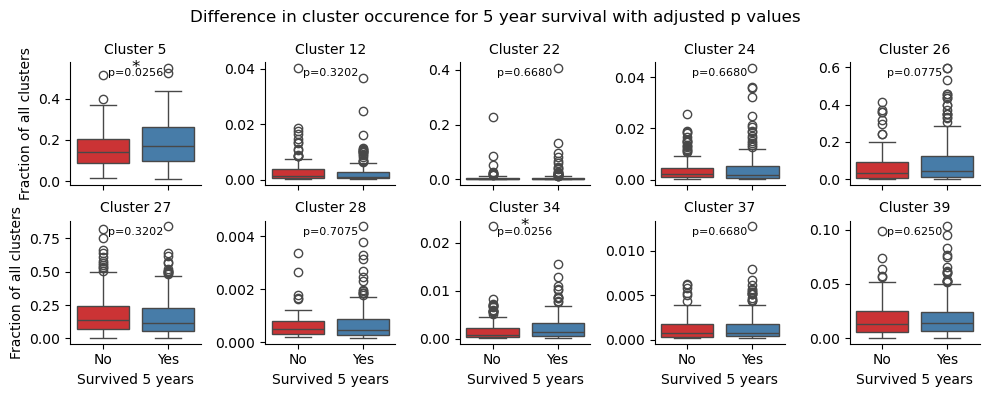

In [264]:
# Plot using Seaborn
# sns.set(style="whitegrid")
g = sns.FacetGrid(boxplot_df_toptreg, col="agglomerateto_40", col_wrap=5, height=2, sharey=False)
g.map_dataframe(sns.boxplot, x="surv_5y", y="relative_frequency", palette="Set1")

g.set_axis_labels("Survived 5 years", "Fraction of all clusters")
g.set_titles("Cluster {col_name}")

# Add p-value annotation to each subplot
i = 0
for ax, (_, data) in zip(g.axes.flat, df.groupby('agglomerateto_40')):
    p_value = pvals_toptreg_adjusted[i]
    i+=1
    if p_value < 0.001:
        ax.text(0.5, 1.02, '***', ha='center', va='top', transform=ax.transAxes, fontsize= 12)
    elif p_value < 0.01:
        ax.text(0.5, 1.02, '**', ha='center', va='top', transform=ax.transAxes, fontsize= 12)
    elif p_value < 0.05:
        ax.text(0.5, 1.02, '*', ha='center', va='top', transform=ax.transAxes, fontsize= 12)

    ax.text(0.5, 0.95, f'p={p_value:.4f}', ha='center', va='top', transform=ax.transAxes, fontsize= 8)

g.set_xticklabels(["No", "Yes"])

g.fig.suptitle('Difference in cluster occurence for 5 year survival with adjusted p values')
plt.subplots_adjust(top=0.85)  # Adjust the top to make room for the title

plt.savefig(f'{data_path}plots/boxplot_toptregclus_clus40__adjusted_pvals.png', bbox_inches='tight', dpi=300)

plt.show()


In [269]:
pvals_all = []
for clus in range(1,41):
    df5 = boxplot_df_all.loc[boxplot_df_all['agglomerateto_40'] == clus]
    # died before 5 years
    low = df5.loc[(df5['surv_5y'] == 0) & df5['death'] == 1]
    # Died or got lost after 5 years
    # People that got lost before 5 years are excluded
    high = df5.loc[(df5['surv_5y'] == 1)]
    pval = mannwhitneyu(high['relative_frequency'], low['relative_frequency'], alternative="two-sided").pvalue
    pvals_all.append(pval)

# Perform Benjamini-Hochberg adjustment
pvals_all_adjusted= sm.multipletests(pvals_all, method='fdr_bh')[1]

# Print the adjusted p-values
print("Original p-values:", pvals_all)
print("Adjusted p-values:", pvals_all_adjusted)

# pvals_all_adjusted

Original p-values: [0.5499185156672899, 0.6874352782374415, 0.42861060991522526, 0.7042505707202609, 0.0044465113728883975, 0.5783127057334227, 0.24516598452584804, 0.04030883861828084, 0.9992401203566633, 0.6545584604838195, 0.21187846141103472, 0.16008794676296123, 0.6339282184732911, 0.9547209454344872, 0.22046537771504016, 0.5517057212119293, 0.7909142091329485, 0.10418126268767584, 0.5823214833928552, 0.019129611067836557, 0.4602260636063784, 0.6011781703531605, 0.45029657655483535, 0.4952088987342118, 0.24187133876165523, 0.023242448968897697, 0.15344046660458363, 0.7075468070542732, 0.542422527665256, 0.7950398514983266, 0.04187722801571854, 0.30255980360278467, 0.029295661263270944, 0.005120866752204937, 0.32822610662738627, 0.1434185349486618, 0.5690180077477516, 0.5685238962036092, 0.3750243797530407, 0.6844426909455659]
Adjusted p-values: [0.78616312 0.78616312 0.78616312 0.78616312 0.10241734 0.78616312
 0.65377596 0.23929845 0.99924012 0.78616312 0.65377596 0.58213799
 0.7

c:\Users\jhroe\anaconda3\envs\bio\Lib\site-packages\seaborn\axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
c:\Users\jhroe\anaconda3\envs\bio\Lib\site-packages\seaborn\axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
c:\Users\jhroe\anaconda3\envs\bio\Lib\site-packages\seaborn\axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
c:\Users\jhroe\anaconda3\envs\bio\Lib\site-packages\seaborn\axisgrid.py:854: FutureWarning: 

Passing `palette` withou

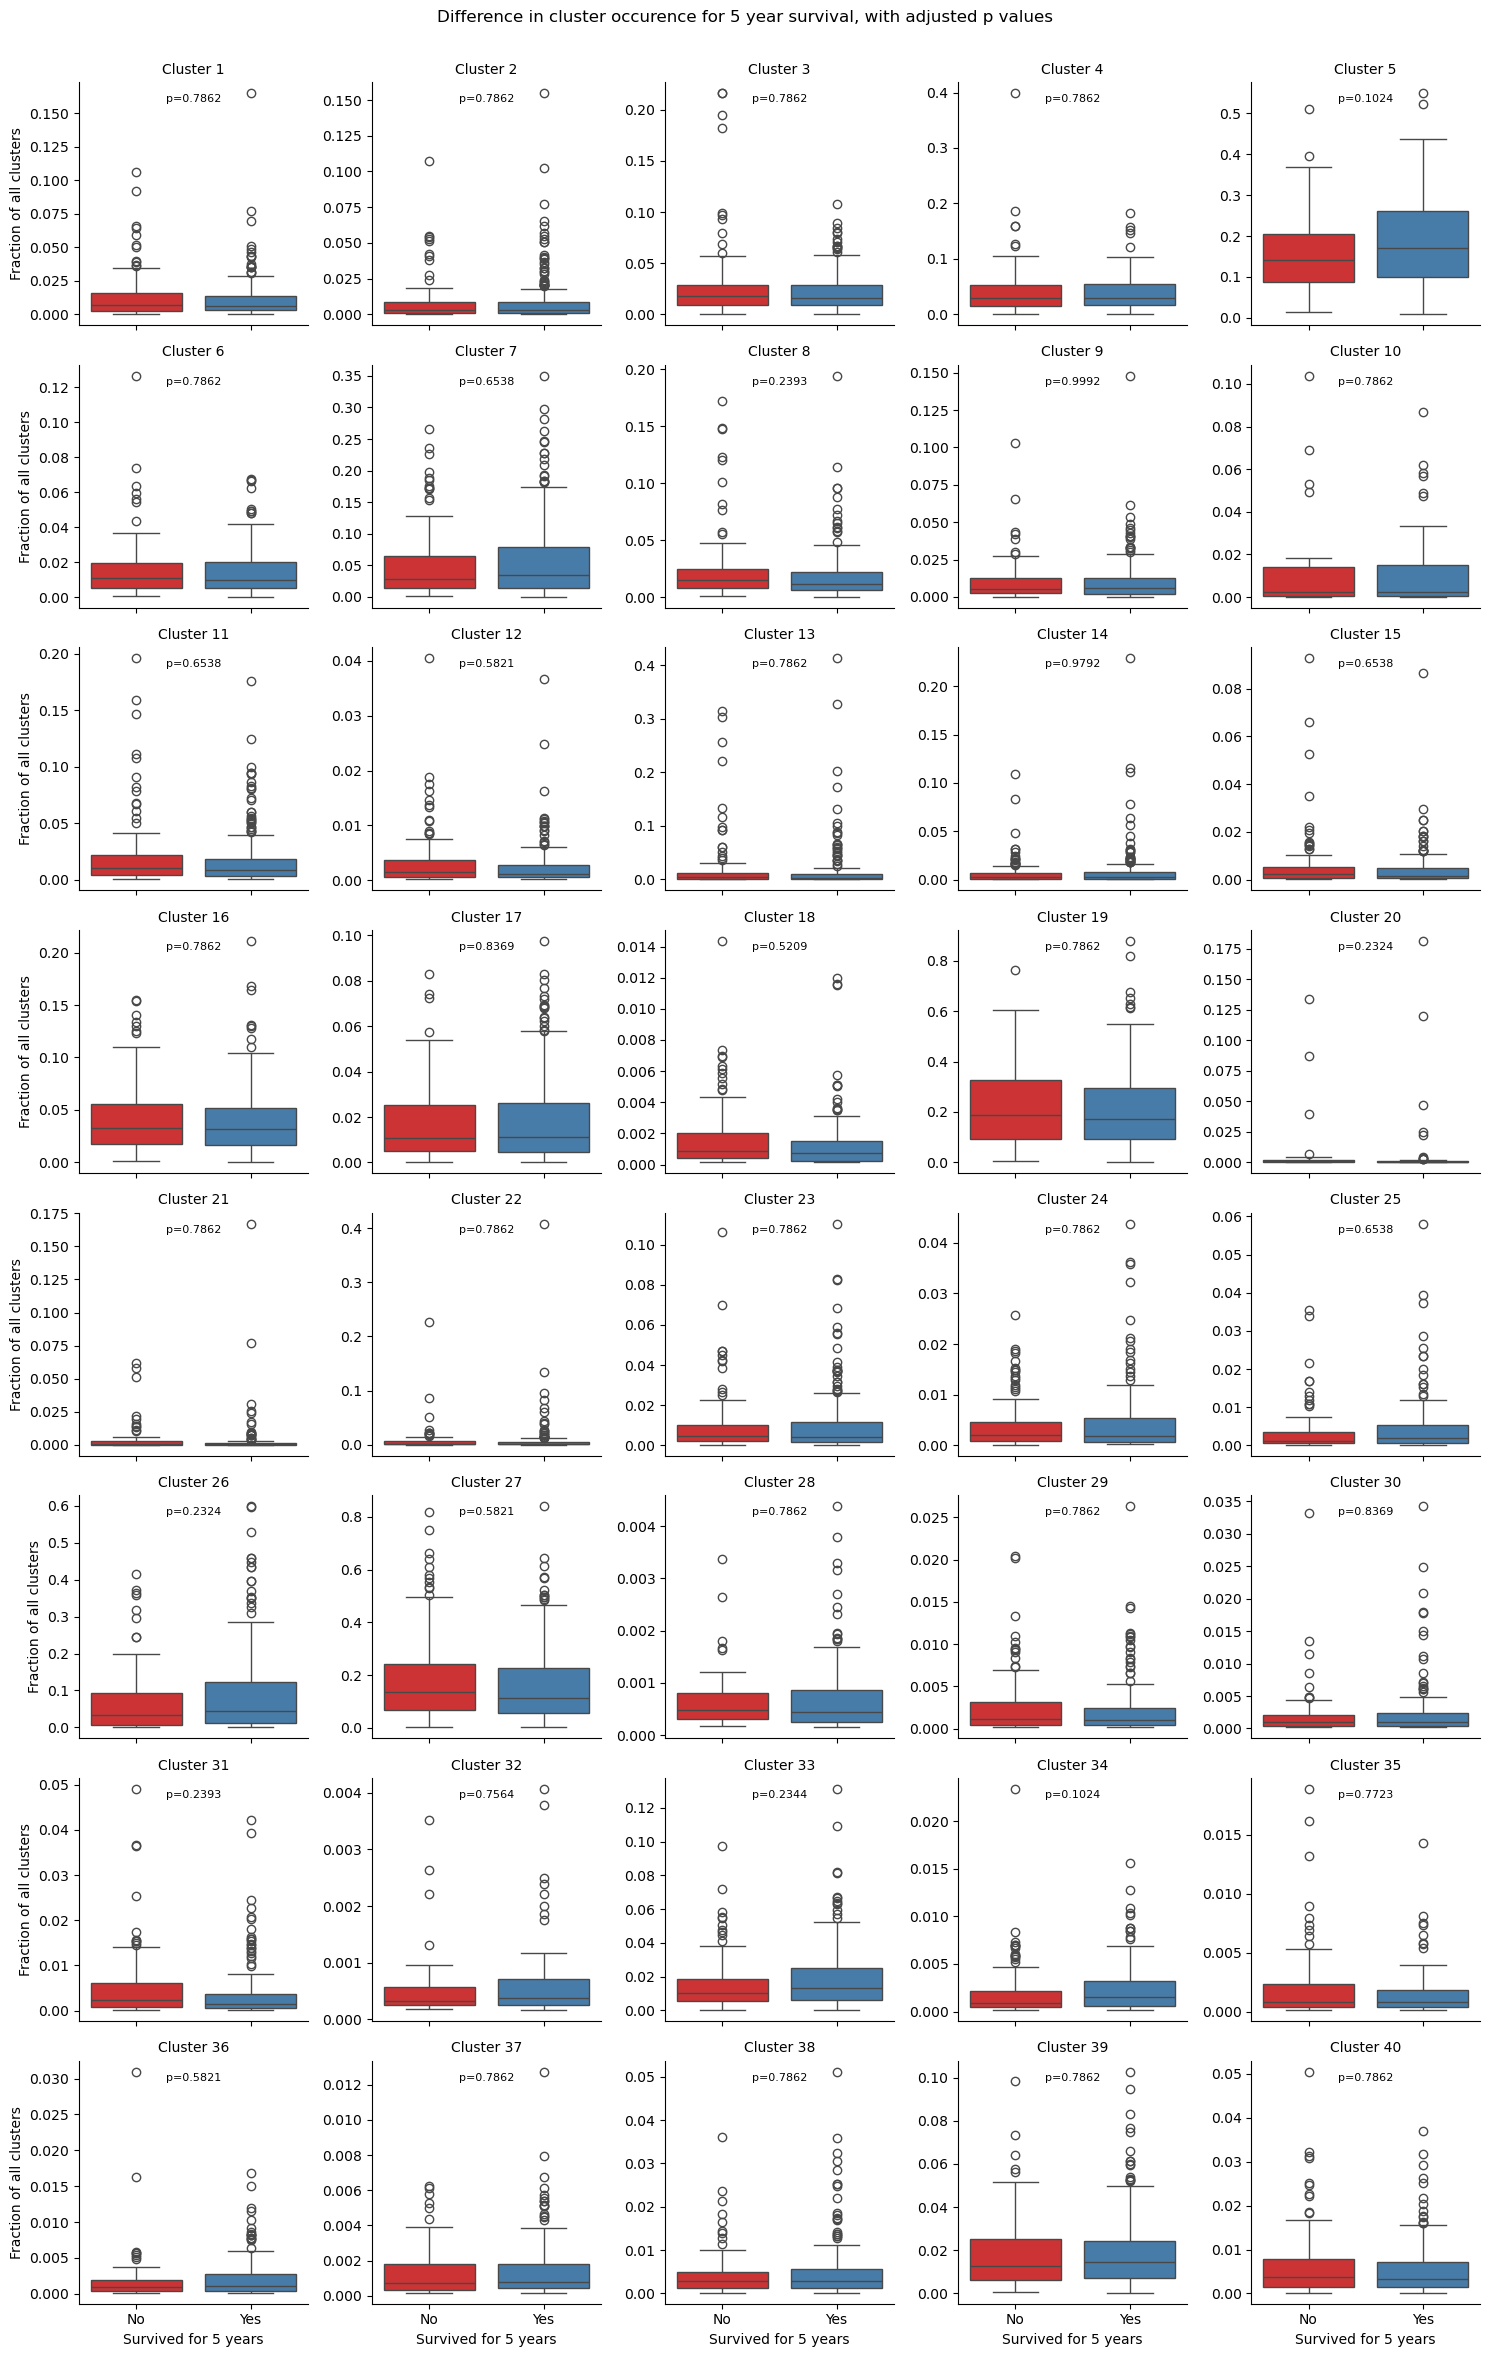

In [270]:
# Plot using Seaborn
# sns.set(style="whitegrid")
g = sns.FacetGrid(boxplot_df_all, col="agglomerateto_40", col_wrap=5, height=3, sharey=False)
g.map_dataframe(sns.boxplot, x="surv_5y", y="relative_frequency", palette="Set1")
g.set_axis_labels("Survived for 5 years", "Fraction of all clusters")
g.set_titles("Cluster {col_name}")

# Add p-value annotation to each subplot
i = 0
for ax, (_, data) in zip(g.axes.flat, df.groupby('agglomerateto_40')):
    p_value = pvals_all_adjusted[i]
    i+=1
    if p_value < 0.001:
        ax.text(0.5, 1.02, '***', ha='center', va='top', transform=ax.transAxes, fontsize= 15)
    elif p_value < 0.01:
        ax.text(0.5, 1.02, '**', ha='center', va='top', transform=ax.transAxes, fontsize= 15)
    elif p_value < 0.05:
        ax.text(0.5, 1.02, '*', ha='center', va='top', transform=ax.transAxes, fontsize= 15)

    ax.text(0.5, 0.95, f'p={p_value:.4f}', ha='center', va='top', transform=ax.transAxes, fontsize= 8)

g.set_xticklabels(["No", "Yes"])

g.fig.suptitle('Difference in cluster occurence for 5 year survival, with adjusted p values')
plt.subplots_adjust(top=0.95)  # Adjust the top to make room for the title

# plt.title('Difference in cluster occurence for long')
plt.savefig(f'{data_path}plots/boxplot_allclus_clus40__adjusted_pvals.png', bbox_inches='tight', dpi=300)

plt.show()


In [183]:
df_pi.rename(columns={'Key':'Patient_ID', 'Survival or loss to follow-up (years)':'survival', 'Death (No: 0, Yes: 1)':'death'}, inplace=True)

surv_clus_corr = pd.merge(boxplot_all, df_pi, on='Patient_ID', how='inner').drop(columns=['surv_5y'])
surv_clus_corr[surv_clus_corr['agglomerateto_40']==1]

C:\Users\jhroe\AppData\Local\Temp\ipykernel_26320\1322816599.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pi.rename(columns={'Key':'Patient_ID', 'Survival or loss to follow-up (years)':'survival', 'Death (No: 0, Yes: 1)':'death'}, inplace=True)


,Patient_ID,agglomerateto_40,relative_frequency,survival,death
0,LUAD_D001,1,0.002657,8.386,1
35,LUAD_D002,1,0.019865,10.111,0
66,LUAD_D003,1,0.017975,2.094,1
104,LUAD_D004,1,0.002832,1.755,1
134,LUAD_D005,1,0.011860,7.598,1
...,...,...,...,...,...
13084,LUAD_D412,1,0.007740,9.944,0
13117,LUAD_D413,1,0.008705,8.132,0
13149,LUAD_D414,1,0.001079,8.550,0
13184,LUAD_D415,1,0.023000,1.862,1


C:\Users\jhroe\AppData\Local\Temp\ipykernel_26320\2986352853.py:31: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  legend.legendHandles[0]._sizes = [20]
C:\Users\jhroe\AppData\Local\Temp\ipykernel_26320\2986352853.py:32: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  legend.legendHandles[1]._sizes = [20]


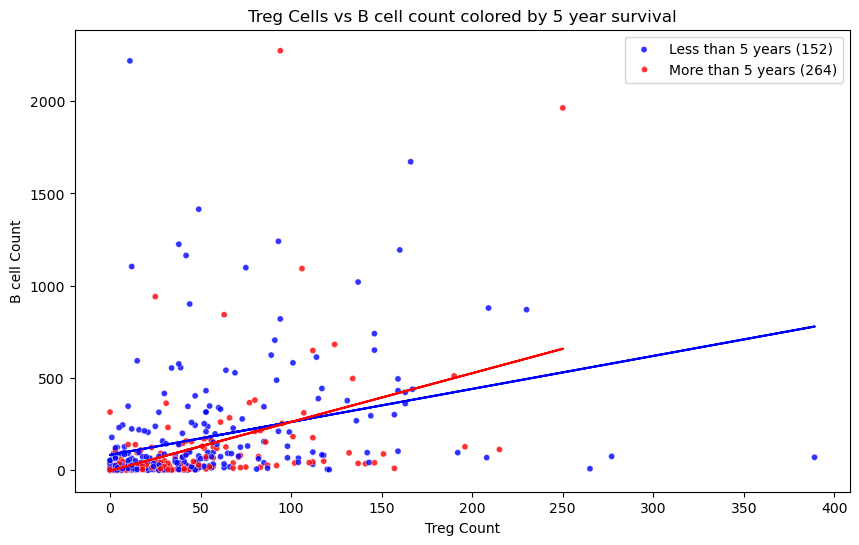

In [187]:
ct1 = 'Treg'
ct2 = 'B cell'
# Filter the DataFrame for Treg and B cells
treg_df = df[df['source_cluster'] == ct1]
b_cells_df = df[df['source_cluster'] == ct2]

# Calculate counts of Treg cells and B cells per patient
count_df = df.groupby(['Patient_ID', 'source_cluster']).size().unstack(fill_value=0).reset_index()

# Merge counts with survival information
merged_df = pd.merge(count_df, df[['Patient_ID', 'surv_5y']], on='Patient_ID').drop_duplicates()
total_surv = merged_df['surv_5y'].sum()
# merged_df
# Plotting
plt.figure(figsize=(10, 6))
sns.scatterplot(x=ct1, y=ct2, hue='surv_5y', data=merged_df, palette={0: 'red', 1: 'blue'},s=20,alpha=0.8)
x = merged_df[merged_df['surv_5y'] == 1][ct1]
y = merged_df[merged_df['surv_5y'] == 1][ct2]
m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x + b, color='blue')
x = merged_df[merged_df['surv_5y'] == 0][ct1]
y = merged_df[merged_df['surv_5y'] == 0][ct2]
m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x + b, color='red')


plt.title(f'{ct1} Cells vs {ct2} count colored by 5 year survival')
plt.xlabel(f'{ct1} Count')
plt.ylabel(f'{ct2} Count')
legend = plt.legend(loc='upper right', labels=[f'Less than 5 years ({416-total_surv})', f'More than 5 years ({total_surv})'], )
legend.legendHandles[0]._sizes = [20]
legend.legendHandles[1]._sizes = [20]
plt.show()

In [188]:
ct1 = 'Treg'
ct2 = 'B cell'
# Create a MultiIndex with all possible combinations
idx = pd.MultiIndex.from_product([df['Patient_ID'].unique(), df['source_cluster'].unique()], names=['Patient_ID', 'source_cluster'])

# Group by and count occurrences
cts_surv = df.groupby(by=['Patient_ID', 'source_cluster', 'surv_5y']).size().reindex(idx, fill_value=0).reset_index(name='count')
# cts_surv = df.groupby(by=['Patient_ID', 'source_cluster', 'surv_5y']).size().unstack(fill_value=0).stack().reset_index(name='count')
# btreg = cts_surv[cts_surv['source_cluster'].isin(['B cell', 'Treg'])]
plt.scatter(cts_surv[cts_surv['source_cluster'] == ct1]['count'], cts_surv[cts_surv['source_cluster'] == ct2]['count'],c='surv_5y', s=1)
plt.xlabel(f'Count of {ct1}')
plt.xlabel(f'Count of {ct2}')

plt.show()
# count_data = data.groupby(['Patient_ID', 'agglomerateto_40', 'surv_5y']).size()


AssertionError: Length of new_levels (3) must be <= self.nlevels (2)

In [206]:
data

,Patient_ID,source_ID,source_cluster,Alt.MAC,B.cell,Cancer,Cl.MAC,Cl.Mo,DCs.cell,Endothelial.cell,...,T.other,Tc,Th,Treg,Unknown,agglomerateto_275,agglomerateto_20,agglomerateto_40,agglomerateto_49,surv_5y
4061,LUAD_D001,D001_1343,Alt MAC,0.166667,0.000000,0.500000,0.166667,0.0,0.0,0.0,...,0.0,0.0,0.0,0.166667,0.000000,74,3,40,40,1
4062,LUAD_D001,D001_1389,Cl MAC,0.300000,0.000000,0.300000,0.300000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,74,3,40,40,1
4063,LUAD_D001,D001_1987,Unknown,0.166667,0.000000,0.333333,0.333333,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.166667,74,3,40,40,1
4064,LUAD_D001,D001_2023,Cancer,0.125000,0.000000,0.750000,0.125000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,74,3,40,40,1
4065,LUAD_D001,D001_2046,Tc,0.285714,0.000000,0.571429,0.142857,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,74,3,40,40,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1637146,LUAD_D213,D213_1665,B cell,0.100000,0.000000,0.700000,0.200000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,74,3,40,40,1
1637147,LUAD_D213,D213_2358,Cancer,0.200000,0.000000,0.600000,0.200000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,74,3,40,40,1
1637148,LUAD_D213,D213_2371,Cancer,0.111111,0.111111,0.555556,0.222222,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,74,3,40,40,1
1637149,LUAD_D213,D213_2553,Cancer,0.100000,0.100000,0.500000,0.300000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,74,3,40,40,1


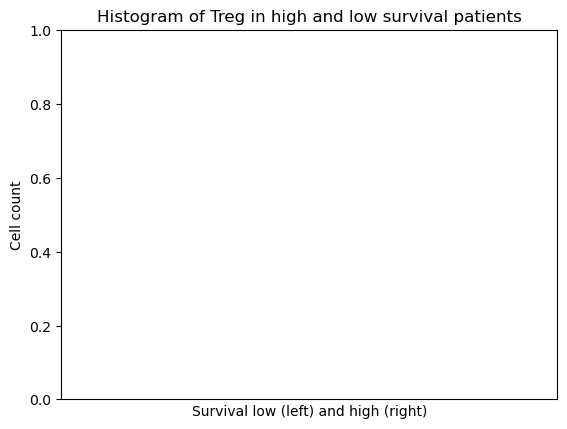

In [ ]:
# Quick and dirty way to visualize distribution cellstypes across survival
ct1 = 'Treg'
ct2 ='B cell'
plt.scatter
plt.xlabel('Survival low (left) and high (right)')
plt.xticks([])
plt.ylabel('Cell count')
plt.title(f'Histogram of {ct} in high and low survival patients')
plt.show()

In [ ]:
from scipy.stats import pearsonr


temp = pd.DataFrame()
temp['survival'] = surv_clus_corr['survival']
temp['relative_frequency'] = surv_clus_corr['relative_frequency']
temp['cluster'] = surv_clus_corr['agglomerateto_40']

# Create a FacetGrid
grid = sns.FacetGrid(temp, col='cluster', col_wrap=3, height=3)
grid.set_titles("Cluster {col_name}")
for ax in grid.axes.flatten():
    ax.tick_params(labelbottom=True)

# Define the function to plot scatter and regression line
def plot_scatter_regression(x, y, color, **kwargs):
    plt.scatter(x, y, color=color, s=1)  # Set size of scatter points to 1
    m, b = np.polyfit(x, y, 1)
    plt.plot(x, m*x + b, color='red')

    # Calculate Pearson correlation coefficient
    corr, _ = pearsonr(x, y)

    plt.ylim(0, 1)
    plt.xlim(0, None)

    # Calculate and plot standard deviation areas
    std = np.std(y - (m * x + b))
    x_fill = np.linspace(min(x), max(x), 50)
    plt.fill_between(x_fill, (m*x_fill + b) - std, (m*x_fill + b) + std, color='red', alpha=0.2)

    # Add correlation coefficient to the plot
    plt.text(0.5, 0.9, f'Pearson correlation: {corr:.2f}', ha='center', va='center', transform=plt.gca().transAxes)


# Map scatter plot and regression line to each plot in the grid
grid.map(plot_scatter_regression, 'survival', 'relative_frequency')

# Set the x-axis labels for each subplot
grid.set_axis_labels('Survival (years)', 'Relative frequency of cluster')

# # Set x-axis labels for each subplot
# for ax, cluster_num in zip(grid.axes.flat, range(1, 41)):
#     ax.set_xlabel(f'Cluster {cluster_num}')
#     ax.set_xticks(np.arange(0, max(temp['survival']) + 1, 5))  # Adjust as needed

    
plt.show()

NameError: name 'surv_clus_corr' is not defined

In [ ]:




# for clus in range(1,41):
#     temp = surv_clus_corr[surv_clus_corr['agglomerateto_40'] == clus]
#     x = temp['survival']
#     y = temp['relative_frequency']

#     # Calculate Pearson correlation coefficient
#     corr, _ = pearsonr(x, y)

#     # Fit a linear regression line
#     m, b = np.polyfit(x, y, 1)

#     # Scatter plot
#     plt.scatter(x, y, s=1)
#     plt.ylim(0, 1)
#     plt.xlim(0, None)


#     # Plot the regression line
#     plt.plot(x, m*x + b, color='red')

#     # Calculate and plot standard deviation areas
#     std = np.std(y - (m * x + b))
#     x_fill = np.linspace(min(x), max(x), 50)
#     plt.fill_between(x_fill, (m*x_fill + b) - std, (m*x_fill + b) + std, color='gray', alpha=0.2)

#     # Add correlation coefficient to the plot
#     plt.text(0.5, 0.9, f'Pearson correlation: {corr:.2f}', ha='center', va='center', transform=plt.gca().transAxes)

#     plt.title(f"Cluster {clus}")
#     plt.xlabel('Survival (years)')
#     plt.ylabel('Relative frequency of cluster')
#     plt.show()
# # plt.sho

In [220]:
surv_clus_corr[surv_clus_corr['agglomerateto_40']== 27].iloc[10:]

,Patient_ID,agglomerateto_40,relative_frequency,survival,death
367,LUAD_D011,27,0.040859,0.783,1
400,LUAD_D012,27,0.241176,1.698,1
432,LUAD_D013,27,0.439470,11.516,0
465,LUAD_D014,27,0.031085,4.876,1
491,LUAD_D015,27,0.372681,10.563,0
...,...,...,...,...,...
13106,LUAD_D412,27,0.063910,9.944,0
13139,LUAD_D413,27,0.140179,8.132,0
13172,LUAD_D414,27,0.095307,8.550,0
13207,LUAD_D415,27,0.089255,1.862,1


In [216]:
surv_clus_corr[surv_clus_corr['agglomerateto_40']== 28]['relative_frequency'].max()

0.00437636761487965

In [202]:
patients_km = surv_clus_corr[['Patient_ID', 'agglomerateto_40', 'survival', 'death']].groupby(['Patient_ID', 'survival', 'agglomerateto_40', 'death']).size().unstack(fill_value=0).reset_index()

patients_km

death,Patient_ID,survival,agglomerateto_40,0,1
0,LUAD_D001,8.386,1,0,1
1,LUAD_D001,8.386,2,0,1
2,LUAD_D001,8.386,3,0,1
3,LUAD_D001,8.386,4,0,1
4,LUAD_D001,8.386,5,0,1
...,...,...,...,...,...
13251,LUAD_D416,9.386,36,1,0
13252,LUAD_D416,9.386,37,1,0
13253,LUAD_D416,9.386,38,1,0
13254,LUAD_D416,9.386,39,1,0


In [200]:

# kaplan meijer plot accoring to Sorin

# Insert cluster for which kaplan meijer needs to be divided
vip_cluster = 10

patients_km = surv_clus_corr[['Patient_ID', 'agglomerateto_40', 'survival']].groupby(['Patient_ID', 'survival', 'agglomerateto_40']).size().unstack(fill_value=0).reset_index()
patients_km.set_index(['Patient_ID', 'survival'], inplace=True)

# Calculate the row totals for scaling
row_totals = patients_km.sum(axis=1)

# Scale every cluster prevalence to 1
normalized_km = patients_km.div(row_totals, axis=0)

# Calculate the z-score for the 'agglomerateto40' column
normalized_km['zscore'] = stats.zscore(normalized_km[[vip_cluster]])
normalized_km.reset_index('survival', inplace=True)

# Sort the DataFrame by survival years in ascending order
df_sorted_km = normalized_km.sort_values(by='survival')

# Create a new column to store the count of people alive when the patient dies
df_sorted_km['percentage_alive'] = 0

# Count the number of patients with survival years greater than or equal to each patient
count_alive = df_sorted_km['survival'].apply(lambda x: (df_sorted_km['survival'] >= x).sum())
# Subtract 1 to exclude the current patient
count_alive -= 1
# Calculate the percentage of people alive
percentage_alive = (count_alive / df_sorted_km.shape[0]) * 100
# Update the 'percentage_alive' column with the calculated percentage
df_sorted_km['percentage_alive'] = percentage_alive

# Filter the dataframe for patients with a z-score of 0 or higher
patients_with_neg_zscore = df_sorted_km[df_sorted_km['zscore'] < 0]
patients_with_pos_zscore = df_sorted_km[df_sorted_km['zscore'] > 0]

print("Amount of people with 0 prevalence exactly:",len(df_sorted_km[df_sorted_km['zscore'] == 0]))

Amount of people with 0 prevalence exactly: 0


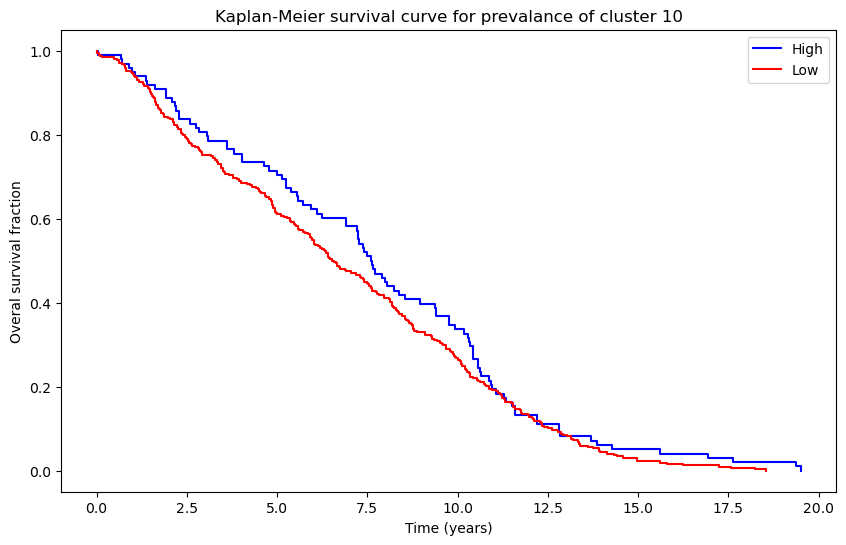

In [165]:
# Create a KaplanMeierFitter object
kmf = KaplanMeierFitter()

event_occurred = [1] * len(patients_with_pos_zscore['survival'])

# Fit the Kaplan-Meier curve to your data
kmf.fit(durations=patients_with_pos_zscore['survival'], event_observed=event_occurred)
# Calculate the survival function at each time point for the first curve
survival_function1 = kmf.survival_function_

# Plot the first curve
plt.figure(figsize=(10, 6))
kmf.plot(label='High', color='blue', ci_show=False)

event_occurred = [1] * len(patients_with_neg_zscore['survival'])

kmf.fit(durations=patients_with_neg_zscore['survival'], event_observed=event_occurred)
kmf.plot(label='Low', color='red', ci_show=False)

# Plot the Kaplan-Meier curve
# kmf.plot_survival_function()
plt.title(f'Kaplan-Meier survival curve for prevalance of cluster {vip_cluster}')
plt.xlabel('Time (years)')
plt.ylabel('Overal survival fraction')
plt.show()

In [161]:

# kaplan meijer plot accoring to Sorin

# Insert cluster for which kaplan meijer needs to be divided
vip_cluster = 26

patients_km = surv_clus_corr[['Patient_ID', 'agglomerateto_40', 'survival']].groupby(['Patient_ID', 'survival', 'agglomerateto_40']).size().unstack(fill_value=0).reset_index()
patients_km.set_index(['Patient_ID', 'survival'], inplace=True)

# Calculate the row totals for scaling
row_totals = patients_km.sum(axis=1)

# Scale every cluster prevalence to 1
normalized_km = patients_km.div(row_totals, axis=0)

# Calculate the z-score for the 'agglomerateto40' column
normalized_km['zscore'] = stats.zscore(normalized_km[[vip_cluster]])
normalized_km.reset_index('survival', inplace=True)

# Sort the DataFrame by survival years in ascending order
df_sorted_km = normalized_km.sort_values(by='survival')

# Create a new column to store the count of people alive when the patient dies
df_sorted_km['percentage_alive'] = 0

# Count the number of patients with survival years greater than or equal to each patient
count_alive = df_sorted_km['survival'].apply(lambda x: (df_sorted_km['survival'] >= x).sum())
# Subtract 1 to exclude the current patient
count_alive -= 1
# Calculate the percentage of people alive
percentage_alive = (count_alive / df_sorted_km.shape[0]) * 100
# Update the 'percentage_alive' column with the calculated percentage
df_sorted_km['percentage_alive'] = percentage_alive

# Filter the dataframe for patients with a z-score of 0 or higher
patients_with_neg_zscore = df_sorted_km[df_sorted_km['zscore'] < 0]
patients_with_pos_zscore = df_sorted_km[df_sorted_km['zscore'] > 0]

print("Amount of people with 0 prevalence exactly:",len(df_sorted_km[df_sorted_km['zscore'] == 0]))

Amount of people with 0 prevalence exactly: 0


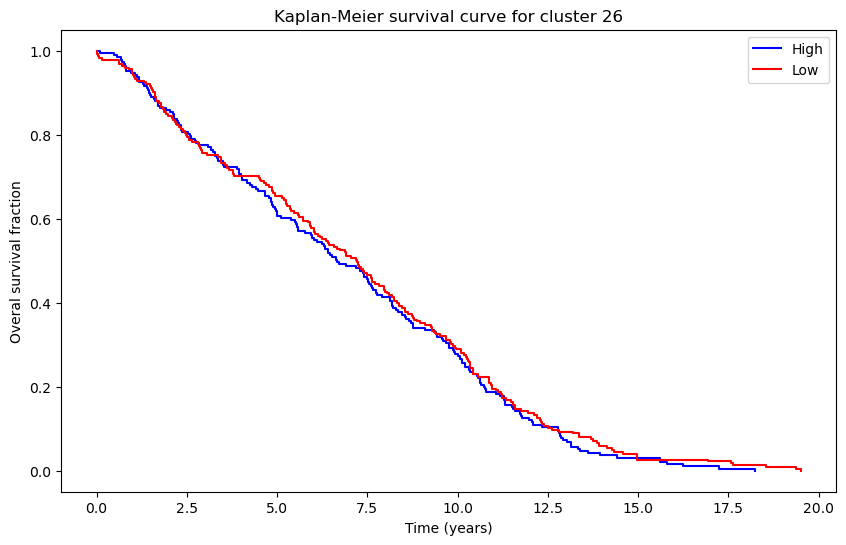

In [162]:
# Create a KaplanMeierFitter object
kmf = KaplanMeierFitter()

event_occurred = [1] * len(patients_with_pos_zscore['survival'])

# Fit the Kaplan-Meier curve to your data
kmf.fit(durations=patients_with_pos_zscore['survival'], event_observed=event_occurred)
# Calculate the survival function at each time point for the first curve
survival_function1 = kmf.survival_function_

# Plot the first curve
plt.figure(figsize=(10, 6))
kmf.plot(label='High', color='blue', ci_show=False)

event_occurred = [1] * len(patients_with_neg_zscore['survival'])

kmf.fit(durations=patients_with_neg_zscore['survival'], event_observed=event_occurred)
kmf.plot(label='Low', color='red', ci_show=False)

# Plot the Kaplan-Meier curve
# kmf.plot_survival_function()
plt.title(f'Kaplan-Meier survival curve for prevalance of cluster {vip_cluster}')
plt.xlabel('Time (years)')
plt.ylabel('Overal survival fraction')
plt.show()

In [266]:
# Old enrichtment heatmap


# enrichment = df_clusct.groupby(['source_cluster', 'agglomerateto_40']).size() / df.groupby('agglomerateto_40').size()
grouped = df[['source_cluster', 'agglomerateto_40']].groupby(['source_cluster', 'agglomerateto_40']).size().unstack(fill_value=0).T
fractions = grouped.div(grouped.sum(axis=1), axis=0)
# Min-Max scaling
min_max_scaled = (fractions - fractions.min()) / (fractions.max() - fractions.min())

# Normalize to range -1 to 1
normalized_df = min_max_scaled * 2 - 1
normalized_df.head()

source_cluster,Alt MAC,B cell,Cancer,Cl MAC,Cl Mo,DCs cell,Endothelial cell,Int Mo,Mast cell,NK cell,Neutrophils,Non-Cl Mo,T other,Tc,Th,Treg,Unknown
agglomerateto_40,,,,,,,,,,,,,,,,,
1,-0.927430,-0.993169,-0.299512,0.045730,-0.928847,-0.566983,-0.798058,-0.573054,-0.652671,-0.902169,-0.962337,-0.469801,-0.500907,-0.802490,-0.823949,-0.619065,-0.716516
2,-0.962911,-0.987769,-0.943421,-0.845727,-0.867295,-0.508202,-0.610105,-0.751332,-0.243916,1.000000,-0.976296,-0.700409,-0.571961,-0.867836,-0.819504,-0.785100,1.000000
3,-0.961267,-0.992867,0.366452,-0.863094,-0.840531,-0.714700,-0.840680,-0.491495,1.000000,-0.909453,-0.982023,-0.699897,0.401128,-0.756924,-0.768761,-0.674605,-0.726200
4,-0.953955,-0.991724,0.652674,-0.923501,-0.966352,-0.793135,-0.905078,-0.576380,-0.800601,-0.926253,-0.988923,-0.757988,-0.479934,-0.518361,-0.748476,-0.679511,-0.940934
5,-0.934869,-0.885289,-0.311903,-0.766105,-0.798113,-0.528400,-0.511253,-0.164030,-0.259207,-0.868084,-0.954071,-0.416130,0.064791,-0.218391,-0.102224,0.061850,-0.793419


In [276]:
from scipy import stats

z_scores = stats.zscore(fractions, axis=0)
# z_scores

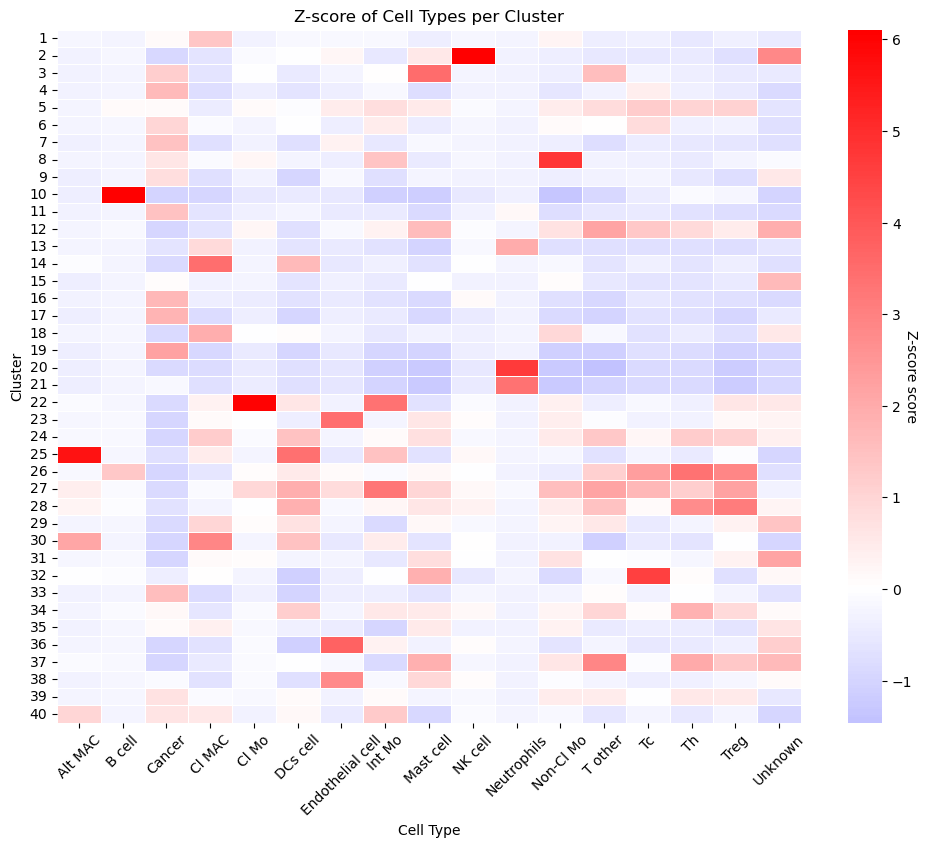

In [278]:
# enrichment = normalized_df
enrichment = z_scores
# Plot heatmap
plt.figure(figsize=(12, 9))
ax = sns.heatmap(enrichment, cmap='bwr', fmt=".2f", linewidths=.5, center=0)

plt.title('Z-score of Cell Types per Cluster')
plt.ylabel('Cluster')
plt.xlabel('Cell Type')
plt.yticks(rotation=0)
plt.xticks(rotation=45)

# Edit the colorbar
cbar = ax.collections[0].colorbar

cbar.set_label('Z-score score', rotation=270) 
# cbar.set_ticks([-1 ,0, 1])
plt.savefig(f"{data_path}/plots/Celltype_Cluster_zscore")
# Show the plot
plt.show()

In [154]:
# New Enrichtment Heatmap
perm_df = df[['source_cluster', 'agglomerateto_40']]

In [195]:
# Calculate enrichment per celltype in cluster 
def observed_enrichment(data):
    # Calculate observed enrichment of cell types within clusters
    observed_enrichment = data.groupby(['agglomerateto_40', 'source_cluster']).size().unstack(fill_value=0)
    observed_enrichment = observed_enrichment.div(observed_enrichment.sum(axis=1), axis=0)
    return observed_enrichment

def calculate_enrichment_score(p_values, observed_enrichment, null_enrichment):
    # Translate p-values to enrichment scores
    enrichment_scores = np.where(observed_enrichment >= null_enrichment, 1 - 2 * p_values, 2 * p_values - 1)
    return enrichment_scores

def permutation_test(data, n_permutations=1000):
    # Compute observed enrichment
    observed = observed_enrichment(data)
    
    permutation_results = np.zeros((n_permutations, observed.shape[0], observed.shape[1]))
    
    # Perform Permutation test
    for i in range(n_permutations):
        shuffled_data = data.copy()
        shuffled_data['source_cluster'] = np.random.permutation(shuffled_data['source_cluster'])
        permuted_enrichment = observed_enrichment(shuffled_data)
        permutation_results[i] = permuted_enrichment.values
    
    observed_statistic = observed.values
    
    # Calculate p-values for both tails
    p_values_upper = np.mean(permutation_results >= observed_statistic, axis=0)
    p_values_lower = np.mean(permutation_results <= observed_statistic, axis=0)
    
    # Compute the two-tailed p-values
    p_values = np.minimum(p_values_upper, p_values_lower) * 2

    # Cap the p-values at 1
    p_values = np.minimum(p_values, 1)
    
    p_values = pd.DataFrame(p_values, columns=observed.columns)


    # Calculate enrichment
    enrichment_scores = calculate_enrichment_score(p_values, observed.values, np.mean(permutation_results, axis=0))
    enrichment_scores = pd.DataFrame(enrichment_scores, columns=observed.columns)
    p_values.index = p_values.index + 1
    enrichment_scores.index = enrichment_scores.index + 1

    return p_values, enrichment_scores

# Example usage
# Assuming your DataFrame is named 'df' with columns 'cluster' and 'cell_type'
p_values, enrichment_scores = permutation_test(df)

# p_values is a DataFrame containing the two-tailed p-values for each combination of cluster and cell type


In [394]:
p_values

source_cluster,Alt MAC,B cell,Cancer,Cl MAC,Cl Mo,DCs cell,Endothelial cell,Int Mo,Mast cell,NK cell,Neutrophils,Non-Cl Mo,T other,Tc,Th,Treg,Unknown
1,0.0000,0.0000,0.0,0.0000,0.0000,0.6702,0.0000,0.0002,0.0002,0.1460,0.0000,0.0444,0.0000,0.0000,0.0000,0.0000,0.0000
2,0.0000,0.0000,0.0,0.0000,0.0006,1.0000,0.0000,0.0000,0.0010,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
3,0.0000,0.0000,0.0,0.0000,0.1612,0.0072,0.0000,0.0000,0.0000,0.0032,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
4,0.0000,0.0000,0.0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0002,0.0000,0.0000,0.0000
5,0.0000,0.0000,0.0,0.0038,0.0000,0.1710,0.0000,0.0000,0.0000,0.6646,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
6,0.0000,0.0000,0.0,0.0000,0.0000,0.9592,0.0000,1.0000,0.0000,0.1038,0.0000,0.2726,0.0060,0.0000,0.0000,0.0000,0.0000
7,0.0000,0.0000,0.0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0014,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
8,0.0000,0.0000,0.0,0.0000,0.0000,0.2284,0.0000,0.0000,0.0000,0.0170,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
9,0.0000,0.0000,0.0,0.0000,0.0000,0.0004,0.0000,0.0000,0.0850,0.0104,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
10,0.0000,0.0000,0.0,0.0000,0.0000,0.3868,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


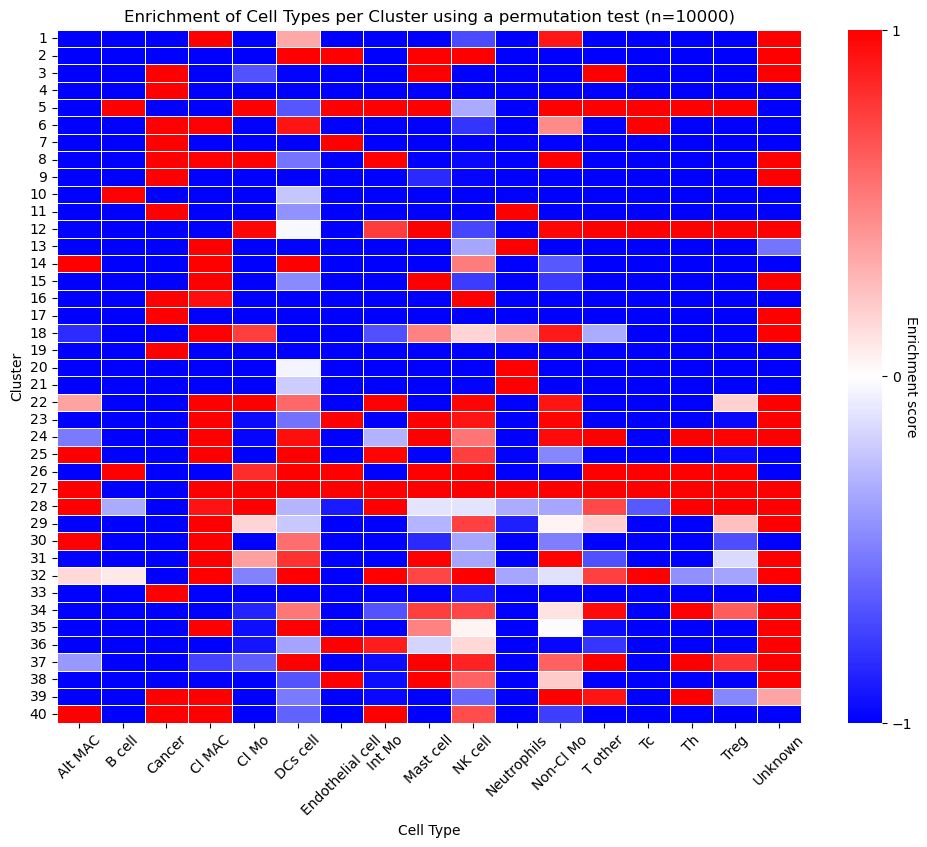

In [208]:
# Plot heatmap
plt.figure(figsize=(12, 9))
ax = sns.heatmap(enrichment_scores, cmap='bwr', fmt=".2f", linewidths=.5, center=0)

plt.title('Enrichment of Cell Types per Cluster using a permutation test (n=10000)')
plt.ylabel('Cluster')
plt.xlabel('Cell Type')
plt.yticks(rotation=0)
plt.xticks(rotation=45)

# Edit the colorbar
cbar = ax.collections[0].colorbar

cbar.set_label('Enrichment score', rotation=270) 
cbar.set_ticks([-1 ,0, 1])
plt.savefig(f"{data_path}/plots/Celltype_Cluster_enrichment_permutation")
# Show the plot
plt.show()